
### **Step 1:**
Read data and inspect.

In [1]:
import pandas as pd
import numpy as np


file_name = 'diabetes_csv.csv'

dataframe = pd.read_csv(file_name)
dataframe.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


Make sure no null values are present:

In [2]:
dataframe.count()

preg     768
plas     768
pres     768
skin     768
insu     768
mass     768
pedi     768
age      768
class    768
dtype: int64

Make sure we have a good number of both classes present in the datset:

In [3]:
dataframe.groupby('class').size()

class
tested_negative    500
tested_positive    268
dtype: int64

### **Step 2:** 
Shuffle data

In [4]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
dataframe.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,5,106,82,30,0,39.5,0.286,38,tested_negative
1,3,96,78,39,0,37.3,0.238,40,tested_negative
2,10,94,72,18,0,23.1,0.595,56,tested_negative
3,5,136,84,41,88,35.0,0.286,35,tested_positive
4,0,84,82,31,125,38.2,0.233,23,tested_negative


Split dataframe into training & testing samples:

In [5]:
instance_count = len(dataframe.index)
training_count = int(0.75 * instance_count)

training_df = dataframe.iloc[ : training_count , : ]
testing_df = dataframe.iloc[training_count : , : ]

print("Number of training instances: ", len(training_df.index),
      ", Number of testing instances: ", len(testing_df.index), ".")

Number of training instances:  576 , Number of testing instances:  192 .


### **Step 3:** 
Split data by class

In [6]:
class_pos = training_df[training_df['class'] == 'tested_positive']
class_neg = training_df[training_df['class'] == 'tested_negative']

# Remove label column
class_pos = class_pos.iloc[:, : -1]
class_neg = class_neg.iloc[:, : -1]

**Computing liklihood for each feature:**

To compute the liklihood for each feature for each class we have to decide first if the feature is a categorical or a continues valued feature, from inspecting the data in the first cell, and from feature descriptions in the problem statement, we observe that the features: _plasma glucose concentration, diastolic blood pressure, triceps skin fold thickness, 2-Hour serum insulin, body mass index, diabetes pedigree function, and age_ **are all continuous features**, but _number of times pregnant_ can be argued that it's a **discrete but numerical** feature.

In that case we can compute the liklihood for that feature using discrete Naive Bayes, but for my solution I'm processing the number of times pregnant as a continuous feature.

**Computing mean and standard deviation vectors for each class:** 

in order to calculate _liklihood_ for each feature for each class.

In [7]:
class_pos_mean = class_pos.mean()
class_pos_std = class_pos.std()

class_neg_mean = class_neg.mean()
class_neg_std = class_neg.std()

### Step 4:
Compute Liklihood of each feature for each class:

**A.** Compute prior prabability of each class:

In [8]:
prior_pos = len(class_pos.index) / training_count
prior_neg = len(class_neg.index) / training_count

# Confirm our calculations are correct:
print("Probability of a negative or postive prediction = ", (prior_pos + prior_neg) * 100, "%.")

Probability of a negative or postive prediction =  100.0 %.


**B.** Build model (function) to predict class given a vector of feautres:
In the function, we first compute the liklihood of all features given each class, then compute the probability of a sample with features _v_ being in _class=pos_ and the probability of _v_ in _class=neg_ and return the class with the highest probability.

In [9]:
from functools import reduce
from scipy.stats import norm

# Returns a prediction for a set of features v
def Predict(v):
    # Compute liklihood for each class
    liklihood_pos = norm.pdf(v, class_pos_mean, class_pos_std)
    liklihood_neg = norm.pdf(v, class_neg_mean, class_neg_std)
    
    # Compute probability of each class
    prob_pos = reduce(lambda x, y: x*y, liklihood_pos ) * prior_pos # (Product of all liklihoods) * prior probability
    prob_neg = reduce(lambda x, y: x*y, liklihood_neg ) * prior_neg
    
    # Return class with maximum probabilty
    if prob_pos > prob_neg:
        return "tested_positive"
    else:
        return "tested_negative"

What a prediction would look like:

In [10]:
Predict([1, 89, 66, 23, 94, 28.1, 0.167, 21])

'tested_negative'

### Step 5
Testing on the test set:

In [11]:
# First split labels from test set:
testing_features = testing_df.iloc[:,:-1]
testing_labels_df = testing_df.iloc[:,-1:]

test_labels = [] # Convert df to list
for i in testing_labels_df.values:
    test_labels.append(i[0])
    
# Make a prediction on all testing instances
prediction = []
for row in (testing_features.values):
    prediction.append(Predict(row))

### Step 6
Computing accuracy, percesion & recall:

In [12]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

# Count parameters by comparing the prediction labels to the testing labels:
for i in range(len(prediction)):
    if prediction[i] == test_labels[i]:
        # This is a true prediction
        # Check if it was a postive or negative true prediction
        if 'tested_positive' in prediction[i]:
            true_pos += 1
        else:
            true_neg += 1
            
    else:
        # This is a false prediction
        # Check if it was a postive or negative false prediction
        if 'tested_positive' in prediction[i]:
            false_pos += 1
        else:
            false_neg += 1


accuracy = (true_pos + true_neg) / len(prediction)
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print("Accuracy = ",accuracy,"\nPercision = ",precision,"\nRecall = ",recall)

Accuracy =  0.7083333333333334 
Percision =  0.6491228070175439 
Recall =  0.5068493150684932


Now train a Gaussian Naive Bayes model using sickit learn and compare results:

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Using the same split used above
x_train = training_df.iloc[:,:-1]

y_train = training_df.iloc[:,-1:]
y_train = y_train.values.ravel()

x_test = testing_features
y_test = testing_labels_df

model = GaussianNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.7083333333333334


### Step 7
Plotting features

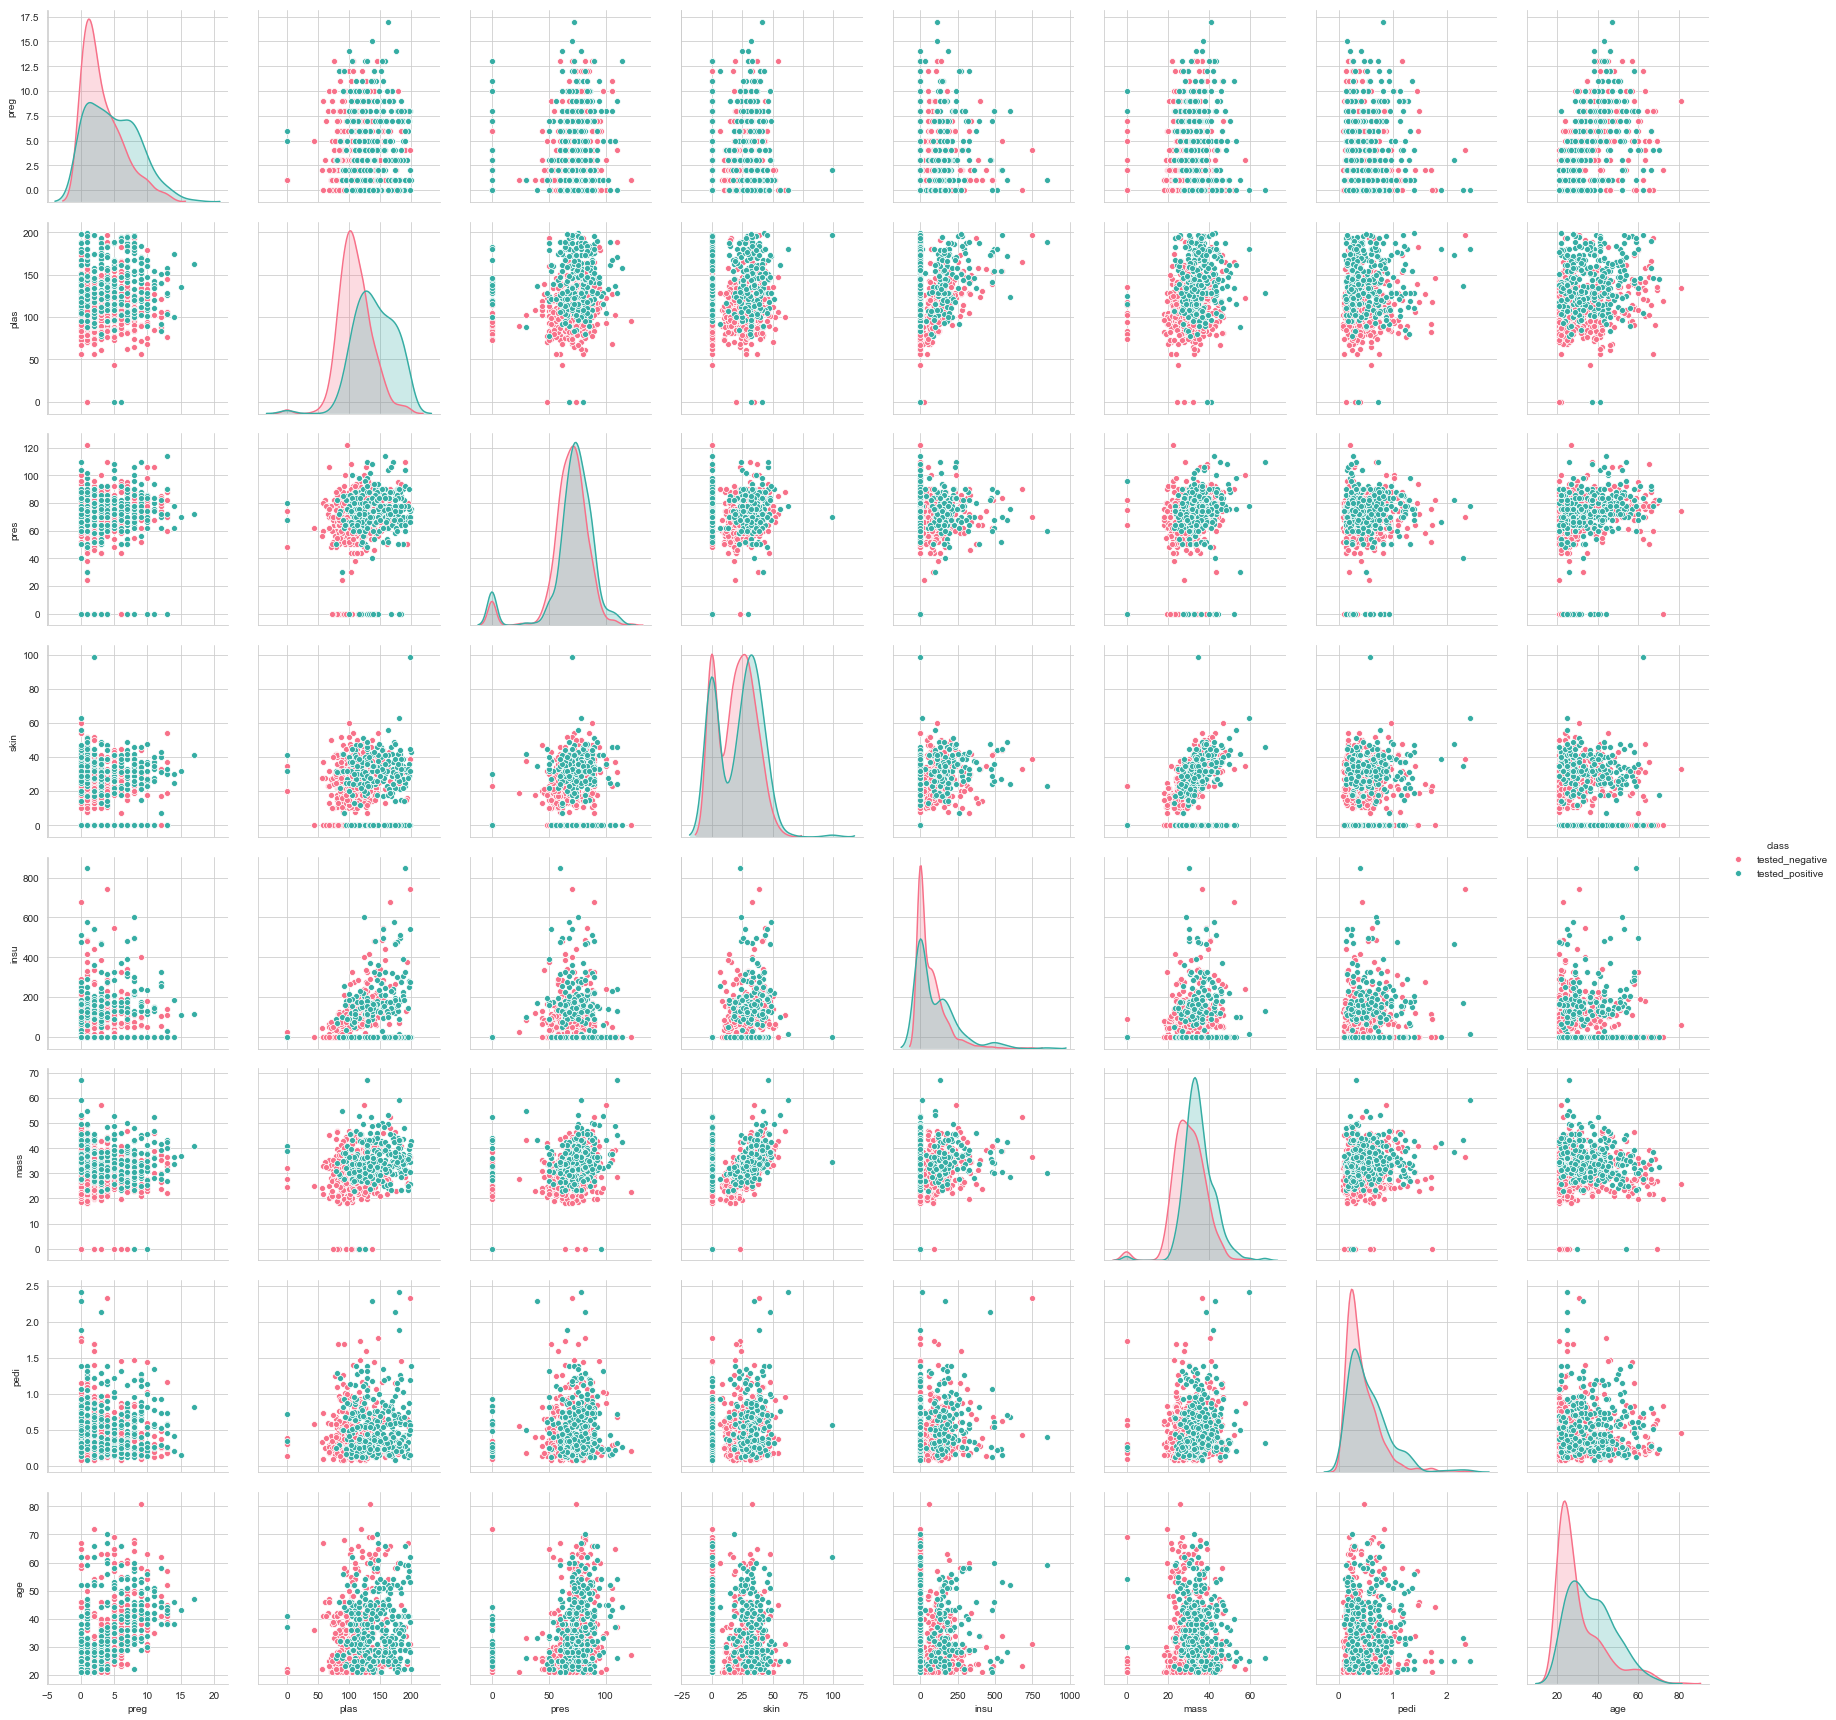

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid");
sns.pairplot(dataframe, hue="class", palette="husl", height=3);
plt.show();

From plotting all the features against eachother, I'm trying to find which two features seperate the data the best (by class), clearly non of the feature seperate the data well, but from obsewrving the different plots, I can say that the features that seperate the data the best might be **plasma against mass**. 

For further exploration I'm plotting plasma against mass:

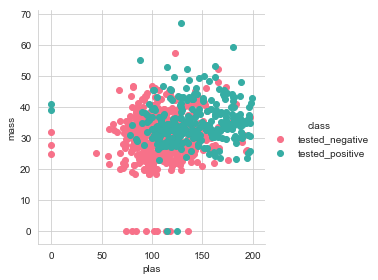

In [16]:
sns.FacetGrid(dataframe, hue="class", palette="husl", height=4) \
   .map(plt.scatter, "plas", "mass") \
   .add_legend()
plt.show()

## Conclusion
The implementation of Gaussian Naive Bayes is a straight forward process, my model gave the exact same accuracy that the the GaussianNB model from sklearn gave if we trained the models on the same split.

From the plot, I cannot conclude which features are highest correlated with postive or negative diabetes diagnoses.


Using the diabetes dataset again, we will perform classification using KNN algorithm.

I will be using the same split as above.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score

x = [1,3,5,10] # Neighbors
acc = []       # Accuracy for neighbor
per = []       # Percision for neighbor
rec = []       # Recall for neighbor

m = KNeighborsClassifier(n_neighbors=x[0], weights='uniform')
m.fit(x_train, y_train)
y_pred = m.predict(x_test)

acc.append(accuracy_score(y_test, y_pred))
per.append(precision_score(y_test, y_pred, pos_label ='tested_positive'))
rec.append(recall_score(y_test, y_pred, pos_label ='tested_positive'))

print("Accuracy=",acc[0],
      "\nPercision = ",per[0],
      "\nRecall = ",rec[0])

Accuracy= 0.6354166666666666 
Percision =  0.5238095238095238 
Recall =  0.4520547945205479


In [18]:
m = KNeighborsClassifier(n_neighbors=x[1], weights='uniform')
m.fit(x_train, y_train)
y_pred = m.predict(x_test)

acc.append(accuracy_score(y_test, y_pred))
per.append(precision_score(y_test, y_pred, pos_label ='tested_positive'))
rec.append(recall_score(y_test, y_pred, pos_label ='tested_positive'))

print("Accuracy=",acc[1],
      "\nPercision = ",per[1],
      "\nRecall = ",rec[1])

Accuracy= 0.6875 
Percision =  0.6031746031746031 
Recall =  0.5205479452054794


In [19]:
m = KNeighborsClassifier(n_neighbors=x[2], weights='uniform')
m.fit(x_train, y_train)
y_pred = m.predict(x_test)

acc.append(accuracy_score(y_test, y_pred))
per.append(precision_score(y_test, y_pred, pos_label ='tested_positive'))
rec.append(recall_score(y_test, y_pred, pos_label ='tested_positive'))

print("Accuracy=",acc[2],
      "\nPercision = ",per[2],
      "\nRecall = ",rec[2])

Accuracy= 0.671875 
Percision =  0.578125 
Recall =  0.5068493150684932


In [20]:
m = KNeighborsClassifier(n_neighbors=x[3], weights='uniform')
m.fit(x_train, y_train)
y_pred = m.predict(x_test)

acc.append(accuracy_score(y_test, y_pred))
per.append(precision_score(y_test, y_pred, pos_label ='tested_positive'))
rec.append(recall_score(y_test, y_pred, pos_label ='tested_positive'))

print("Accuracy=",acc[3],
      "\nPercision = ",per[3],
      "\nRecall = ",rec[3])

Accuracy= 0.6875 
Percision =  0.6326530612244898 
Recall =  0.4246575342465753


Plotting the accuracy against number of neighbors:

In [21]:
acc = np.multiply(acc,100)
per = np.multiply(per,100)
rec = np.multiply(rec,100)

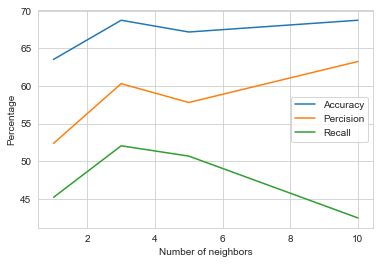

In [22]:

plt.plot(x,acc,label="Accuracy");
plt.plot(x,per,label="Percision");
plt.plot(x,rec,label="Recall");
plt.xlabel('Number of neighbors');
plt.ylabel('Percentage');
plt.legend();

# Conclusion
As the number of neigbors increases, we get a better accuracy for the model, also a better percision score, but for `n>5`, the recall suffers.

So for a good overall score for this datset, `n=5` is the best number of neighbors.